# Laboratorio 8 - Word Embeddings
## <font size=4> *CC3092 - Deep Learning y Sistemas Inteligentes*, 2024 </font>
## <font size=3 color='gray'> Samuel Chamale y Adrian Rodriguez</font>

### Generar Embeddings con Word2Vec

In [25]:
# Importar las librerías necesarias
import gensim
import re
from gensim.models import Word2Vec
import pandas as pd
import nltk
from nltk.tokenize import word_tokenize
import string
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

In [26]:
# Descargar recursos de NLTK (si no se han descargado previamente)
nltk.download('punkt')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\chama\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [27]:
# Cargar los datos desde el archivo de texto
# Se intentó con 'utf-8' pero no funcionó
# al parecer el archivo está codificado en 'latin1', fue coincidencia haberlo descubierto,
# probé con varios y este fue el único que funcionó (e.g. 'utf-8', 'utf-16', 'utf-32', 'ascii', 'cp1252')
with open('reviews_data.txt', 'r', encoding='latin1') as file:
    documents = file.readlines()

*Datos extraidos de https://www.kaggle.com/datasets/imnoob/reviews-dataset-cars-and-hotel?resource=download*

In [28]:
# Lista para almacenar solo las reseñas
reviews = []
malformed_lines = 0

for line in documents:
    sections = line.strip().split('\t')
    if len(sections) == 3:
        date, title, review = sections
        reviews.append(review)
    else:
        malformed_lines += 1

print(f"Se encontraron {malformed_lines} líneas mal formadas (esto significa un porcentaje de: {malformed_lines/len(documents)*100:.2f}%)")

Se encontraron 28957 líneas mal formadas (esto significa un porcentaje de: 11.30%)


In [29]:
# Preprocesar los documentos AKA reseñas
def preprocess(text):
    # Convertir a minúsculas
    text = text.lower()

    # Reemplazar puntuación con espacios usando regex
    # Esto evita la concatenación de palabras
    text = re.sub(r'[^\w\s]', ' ', text)

    # Tokenizar
    tokens = word_tokenize(text)

    # Opcional: eliminar tokens que no sean puramente alfabéticos
    tokens = [word for word in tokens if word.isalpha()]

    return tokens

In [30]:
# Aplicar preprocesamiento a todos los documentos
processed_docs = [preprocess(review) for review in reviews]

In [31]:
model = Word2Vec(
    sentences=processed_docs,
    vector_size=100,  # Tamaño del vector de embeddings
    window=5,         # Tamaño de la ventana de contexto
    min_count=5,      # Ignorar palabras con frecuencia menor a 5
    workers=4,        # Número de hilos para el entrenamiento
    sg=0              # Uso de CBOW (sg=1 para Skip-gram)
)

**Elección de Parámetros**:

- vector_size=100: Un tamaño de vector mayor permite capturar más información semántica.
- window=5: Un tamaño de ventana estándar que equilibra el contexto local y global.
- min_count=5: Filtra palabras raras que podrían no ser informativas.
- workers=4: Utiliza 4 hilos para acelerar el entrenamiento.

In [32]:
model.train(processed_docs, total_examples=len(processed_docs), epochs=10)

(294622642, 415389570)

In [33]:
# Guardar el modelo entrenado
# model.save("word2vec_review_data.model")

In [34]:
# Cargar el modelo entrenado
# model = Word2Vec.load("word2vec_review_data.model")

### Encontrar las 10 Palabras Más Similares

Utilizaremos la función `most_similar` para cada una de las palabras objetivo.

In [35]:
# Lista de palabras objetivo
target_words = ['street', 'good', 'dog', 'mother', 'bed']

# Diccionario para almacenar las palabras similares
similar_words = {}

for word in target_words:
    if word in model.wv:
        similar = model.wv.most_similar(word, topn=10)
        similar_words[word] = [w for w, score in similar]
        print(f"Palabras similares a '{word}': {similar_words[word]}")
    else:
        print(f"La palabra '{word}' no se encuentra en el vocabulario.")
        similar_words[word] = []

Palabras similares a 'street': ['road', 'streetthe', 'rd', 'steet', 'streetit', 'streeti', 'streetits', 'st', 'stree', 'streeta']
Palabras similares a 'good': ['decent', 'great', 'terrific', 'goodthe', 'nice', 'excellent', 'fantastic', 'fab', 'superb', 'excellentthe']
Palabras similares a 'dog': ['dogs', 'child', 'baby', 'pup', 'cat', 'pet', 'companion', 'doll', 'toddler', 'swimsuit']
Palabras similares a 'mother': ['father', 'niece', 'mom', 'mum', 'sisterinlaw', 'cousin', 'daughter', 'neice', 'brother', 'nephew']
Palabras similares a 'bed': ['beds', 'bedthe', 'sofabed', 'mattress', 'daybed', 'bed2', 'bedsour', 'hideabed', 'bedwe', 'bedsclean']


Extraeremos los embeddings de las 5 palabras iniciales más sus 10 similares cada una, totalizando 55 palabras.

In [36]:
# Extraer las 55 palabras
words_to_extract = set(target_words)  # Incluir las palabras iniciales

for word, similars in similar_words.items():
    words_to_extract.update(similars)

# Verificar la cantidad de palabras
print(f"Total de palabras a extraer: {len(words_to_extract)}")

# Extraer los embeddings
word_embeddings = {}
for word in words_to_extract:
    if word in model.wv:
        word_embeddings[word] = model.wv[word]
    else:
        print(f"La palabra '{word}' no se encuentra en el vocabulario.")

print(f"Embeddings extraídos para {len(word_embeddings)} palabras.")

Total de palabras a extraer: 55
Embeddings extraídos para 55 palabras.


### Aplicar PCA y Crear el Gráfico de Dispersión

Reduciremos la dimensionalidad de los embeddings a 2 componentes principales y visualizaremos las palabras.

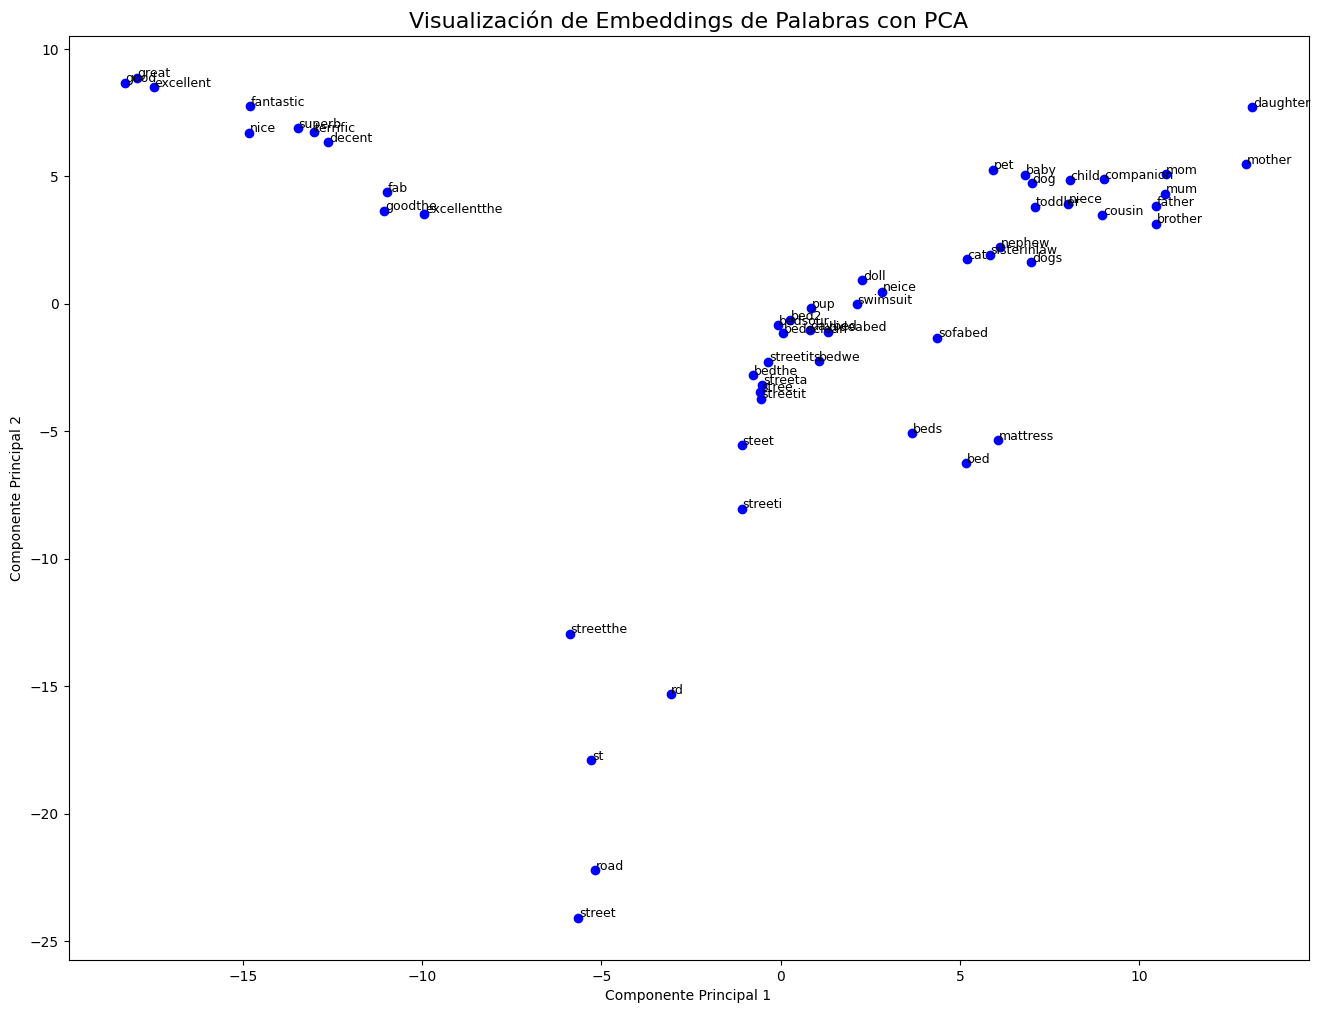

In [37]:
# Convertir los embeddings a una lista
embeddings = list(word_embeddings.values())
labels = list(word_embeddings.keys())

# Aplicar PCA
pca = PCA(n_components=2)
pca_result = pca.fit_transform(embeddings)

# Crear un DataFrame para facilitar la visualización
df_pca = pd.DataFrame({
    'word': labels,
    'x': pca_result[:,0],
    'y': pca_result[:,1]
})

# Configurar el tamaño del gráfico
plt.figure(figsize=(16, 12))

# Crear el gráfico de dispersión
plt.scatter(df_pca['x'], df_pca['y'], color='blue')

# Añadir etiquetas a cada punto
for i, row in df_pca.iterrows():
    plt.text(row['x']+0.02, row['y']+0.02, row['word'], fontsize=9)

# Título y etiquetas
plt.title('Visualización de Embeddings de Palabras con PCA', fontsize=16)
plt.xlabel('Componente Principal 1')
plt.ylabel('Componente Principal 2')

# Mostrar el gráfico
plt.show()